<a href="https://colab.research.google.com/github/AnIsAsPe/ClassificadorCancerEsofago/blob/master/PerceptronClasificadorCancerEs%C3%B3fago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de tejido sano y tejido cancerígeno en imagenes microscópicas del esófago

![image.png](https://drive.google.com/uc?id=1K_j4CnOJeOmiROBiFwEW1M-kJkizrMk7)

## Paso 1. Cargar librerías y módulos requerdidos

In [2]:
import os            # módulo para manejar carpetas y archivos en nuestro ordenador
import random        # módulo para aleatorizar

import numpy as np   # librería para manejar matrices y operaciones de matrices 
import pandas as pd  # librería para manejar tablas de datos

                        #Skimage (Scikit-image): librería para procesamiento de imagenes
from skimage import io  #Modulo para leer una imagen (librería para procesamiento de imagenes)

                                                       #Sklearn (Scikit-learn): librería para machine learning 
from sklearn.model_selection import train_test_split   
from sklearn.linear_model import Perceptron 
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt        #Para graficar y visualizar
import seaborn as sns   

## Paso 2. Lectura de datos. 

### 2.1 Lectura de etiquetas (Y)

In [3]:
#Leemos los datos

datos = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/ClassificadorCancerEsofago/master/ClasesImagenes.csv', usecols=[1,2])


In [4]:
datos.head()  #muestra los primeros cinco registros

,image_filename,class_number
0,im_4_0.png,0
1,im_21_0.png,0
2,im_9_0.png,0
3,im_8_0.png,0
4,im_15_0.png,0


In [5]:
#¿Con cuántas imagenes vamos a trabajar?

datos.shape[0]

5063

In [6]:
#¿cuántas imagenes tenemos de cada clase?

datos['class_number'].value_counts(sort=False)  

0    1469
1    3594
Name: class_number, dtype: int64

Clase 0 corresponde a tejido sano y Clase 1 a tejido Cancerígeno

In [7]:
Y = datos['class_number']  #Guardamos las etiquetas de las imagenes como serie de pandas


### 2.2 Lectura de imágenes (X)

**Lo primero que tenemos que hacer es descomprimir el archivo zip que guardamos en nuestro dirve**

In [8]:

#!unzip -u "/content/drive/MyDrive/Datos/DatosCancer/CarpetaImagenes.zip" -d "/content/drive/MyDrive/Datos/DatosCancer/Unzip"


**Al nombre de las imagenes que están en la primera columna de nuestro dataframe  ```datos``` necesitamos añadirle la ruta del directorio en el que se encuentran las imagenes descomprimidas**

In [9]:
datos.head()

,image_filename,class_number
0,im_4_0.png,0
1,im_21_0.png,0
2,im_9_0.png,0
3,im_8_0.png,0
4,im_15_0.png,0


In [10]:
carpeta = "/content/drive/MyDrive/Datos/DatosCancer/Unzip"

enlace_imagenes = datos['image_filename'].apply(lambda x: os.path.join(carpeta, x))

enlace_imagenes.head(3)

0    /content/drive/MyDrive/Datos/DatosCancer/Unzip...
1    /content/drive/MyDrive/Datos/DatosCancer/Unzip...
2    /content/drive/MyDrive/Datos/DatosCancer/Unzip...
Name: image_filename, dtype: object

In [11]:
for i in range(5):
  print(i, enlace_imagenes[i])

0 /content/drive/MyDrive/Datos/DatosCancer/Unzip/im_4_0.png
1 /content/drive/MyDrive/Datos/DatosCancer/Unzip/im_21_0.png
2 /content/drive/MyDrive/Datos/DatosCancer/Unzip/im_9_0.png
3 /content/drive/MyDrive/Datos/DatosCancer/Unzip/im_8_0.png
4 /content/drive/MyDrive/Datos/DatosCancer/Unzip/im_15_0.png


In [12]:
%time  img = enlace_imagenes.apply(lambda x: io.imread(x, as_gray=True))

CPU times: user 36.7 s, sys: 4.35 s, total: 41 s
Wall time: 15min 44s


In [13]:
#Cargamos las imagenes del conjunto d entrenamiento como lista de matrices (np.arrays)
# (10 min ultima vez corrido en colab)

#%time img= [io.imread(i, as_gray=True) for i in datos['image_filename'][:]]

In [14]:
img[1].shape   # dimensión 67,200

(260, 260)

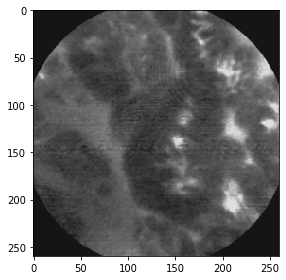

In [15]:
io.imshow(img[500]) 

- Dimensión 0: 260 renglones de pixeles de arriba a abajo
- Dimensión 1: 260 columnas de pixeles de izquierda a derecha


####  Transformar imágenes en vectores
Lo primero es transformar la secuencia img en una matriz


In [16]:
img.values[0].shape

(260, 260)

In [17]:
IMG = np.stack(img, axis=0)  # Toma una secuencia de matrices y las apila a lo largo 
                              # de un tercer eje para hacer una sola matriz              
IMG.shape

(5063, 260, 260)

Despues aplanar la matriz de 2D (260x260 pixeles) de cada imagen, para obtener un vector por imagen. 

In [18]:
X = IMG.reshape(5063, -1)
X.shape

(5063, 67600)

##### Visualizamos ejemplos de ambas clases de imagenes

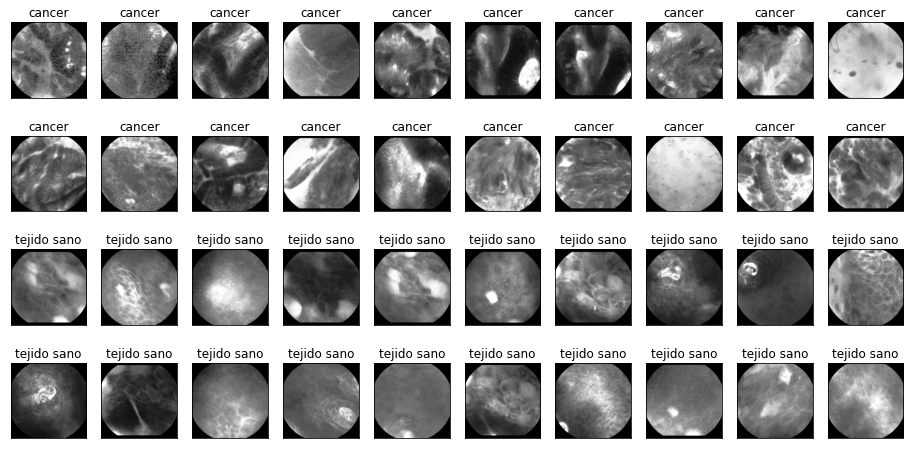

In [19]:
#El método GroupBy de Pandas separa un data frame en varios data frames
porClase = datos.groupby('class_number')

#elije al azar n muestras de cada subconjunto y guarda la posición de las figuras elegidas en una lista
n = 20
c = random.sample(porClase.get_group(1).index.tolist(), n) # indices de las imagenes cancerígenas seleccionadas
s = random.sample(porClase.get_group(0).index.tolist(), n) # indices de las imagenes sanas seleccionadas

# Grafica 20 imágenes aleatorias de tejido con cáncer y 20 de tejido sano

fig = plt.figure(figsize=(16, 8))
columns = 10
rows = 4
for i in range(0, columns * rows):
    fig.add_subplot( rows, columns, i+1)
    if i < 20:
        plt.imshow(img[c[i]], cmap='Greys_r')
        plt.title('cancer')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow(img[s[i-20]], cmap='Greys_r')
        plt.title('tejido sano')
        plt.xticks([])
        plt.yticks([])
plt.show()

## Paso 3. Entrenamiento utilizando perceptrón simple con conjunto de entrenamiento y prueba

### 3.1  Crear subconjuntos de entrenamiento y prueba



In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, 
                                                    shuffle=True, random_state=0)

In [21]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Training set")
print("X: ", X_train.shape)
print("Y: ", y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print('Tejido Sano:        ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')


print("Test set")
print("X: ", X_test.shape)
print("Y: ", y_test.shape)
unique, counts = np.unique(y_test, return_counts=True)
print('Tejido Sano:         ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')

Training set
X:  (3544, 67600)
Y:  (3544,)
Tejido Sano:         1043 
Displasia o Cáncer:  2501 

Test set
X:  (1519, 67600)
Y:  (1519,)
Tejido Sano:          426 
Displasia o Cáncer:  1093 



### 3.2  Entrenamiento



In [22]:
model = Perceptron(max_iter=1000,  random_state=0, verbose=True) 
model.fit(X_train,y_train)                                  

print("Iterations: ", model.n_iter_)

-- Epoch 1
Norm: 1123.26, NNZs: 67600, Bias: -39.000000, T: 3544, Avg. loss: 1641.286726
Total training time: 0.56 seconds.
-- Epoch 2
Norm: 1709.08, NNZs: 67600, Bias: -56.000000, T: 7088, Avg. loss: 1415.700003
Total training time: 1.09 seconds.
-- Epoch 3
Norm: 2155.80, NNZs: 67600, Bias: -69.000000, T: 10632, Avg. loss: 1231.936834
Total training time: 1.60 seconds.
-- Epoch 4
Norm: 2616.13, NNZs: 67600, Bias: -76.000000, T: 14176, Avg. loss: 1124.851144
Total training time: 2.11 seconds.
-- Epoch 5
Norm: 3021.59, NNZs: 67600, Bias: -75.000000, T: 17720, Avg. loss: 1133.721658
Total training time: 2.63 seconds.
-- Epoch 6
Norm: 3379.11, NNZs: 67600, Bias: -74.000000, T: 21264, Avg. loss: 971.851823
Total training time: 3.13 seconds.
-- Epoch 7
Norm: 3724.07, NNZs: 67600, Bias: -66.000000, T: 24808, Avg. loss: 937.594908
Total training time: 3.63 seconds.
-- Epoch 8
Norm: 4026.70, NNZs: 67600, Bias: -68.000000, T: 28352, Avg. loss: 855.373414
Total training time: 4.12 seconds.
-- Ep

In [23]:
#Guardamos los coeficientes del modelo como beta

beta = model.coef_
print(beta.shape)

(1, 67600)


In [24]:
beta[0, 50310:50320]

array([ -1.92002706,  26.43550275,  48.33832196,  60.5412651 ,
        36.79920392,  20.46658157,  -2.35208118, -16.18895686,
       -16.80207686,   4.81493412])

In [25]:
y_predict = model.predict(X_test)  #pasa cada una de las imágenes de X_test por el modelo 

In [26]:
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_predict)*100))

Accuracy: 90.19%


In [27]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 95.49%
Precisión conjunto prueba: 90.19%


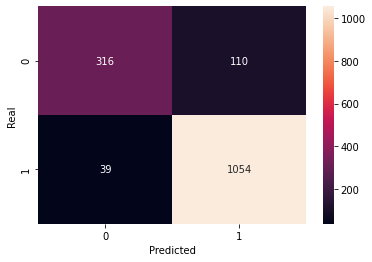

In [28]:
#Matriz de confusión

data = {'Y_Real':  y_test,
        'Y_Prediccion':y_predict
        }

df = pd.DataFrame(data, columns=['Y_Real','Y_Prediccion'])
confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

## Paso 4. Entrenamiento de perceptron utilizando margen

In [29]:
model2 = Perceptron(max_iter=1000,  random_state=0, verbose=True, penalty='l2',  alpha=0.0001) 
model2.fit(X_train,y_train)                                  

print("Precisión conjunto entrenamiento: %.2f%%" % (model2.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model2.score(X_test, y_test)*100.0))


-- Epoch 1
Norm: 956.49, NNZs: 67600, Bias: -45.000000, T: 3544, Avg. loss: 1663.549254
Total training time: 0.57 seconds.
-- Epoch 2
Norm: 1297.28, NNZs: 67600, Bias: -71.000000, T: 7088, Avg. loss: 1484.146212
Total training time: 1.10 seconds.
-- Epoch 3
Norm: 1487.48, NNZs: 67600, Bias: -94.000000, T: 10632, Avg. loss: 1342.727950
Total training time: 1.62 seconds.
-- Epoch 4
Norm: 1584.17, NNZs: 67600, Bias: -110.000000, T: 14176, Avg. loss: 1347.351197
Total training time: 2.15 seconds.
-- Epoch 5
Norm: 1642.57, NNZs: 67600, Bias: -124.000000, T: 17720, Avg. loss: 1318.427635
Total training time: 2.68 seconds.
-- Epoch 6
Norm: 1638.52, NNZs: 67600, Bias: -132.000000, T: 21264, Avg. loss: 1204.883057
Total training time: 3.19 seconds.
-- Epoch 7
Norm: 1686.24, NNZs: 67600, Bias: -149.000000, T: 24808, Avg. loss: 1300.101522
Total training time: 3.71 seconds.
-- Epoch 8
Norm: 1767.77, NNZs: 67600, Bias: -166.000000, T: 28352, Avg. loss: 1276.044756
Total training time: 4.24 seconds

In [30]:
model3 = Perceptron(max_iter=1000,  random_state=0, verbose=True, penalty='l2', alpha=0.000005) 
model3.fit(X_train,y_train)                                  

print("Precisión conjunto entrenamiento: %.2f%%" % (model2.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model2.score(X_test, y_test)*100.0))


-- Epoch 1
Norm: 1080.33, NNZs: 67600, Bias: -38.000000, T: 3544, Avg. loss: 1636.005336
Total training time: 0.57 seconds.
-- Epoch 2
Norm: 1690.26, NNZs: 67600, Bias: -60.000000, T: 7088, Avg. loss: 1442.916757
Total training time: 1.09 seconds.
-- Epoch 3
Norm: 2121.29, NNZs: 67600, Bias: -71.000000, T: 10632, Avg. loss: 1265.319968
Total training time: 1.60 seconds.
-- Epoch 4
Norm: 2547.83, NNZs: 67600, Bias: -74.000000, T: 14176, Avg. loss: 1178.459801
Total training time: 2.12 seconds.
-- Epoch 5
Norm: 2878.70, NNZs: 67600, Bias: -76.000000, T: 17720, Avg. loss: 1076.948152
Total training time: 2.63 seconds.
-- Epoch 6
Norm: 3205.12, NNZs: 67600, Bias: -73.000000, T: 21264, Avg. loss: 998.845010
Total training time: 3.13 seconds.
-- Epoch 7
Norm: 3528.04, NNZs: 67600, Bias: -75.000000, T: 24808, Avg. loss: 957.843483
Total training time: 3.63 seconds.
-- Epoch 8
Norm: 3824.63, NNZs: 67600, Bias: -71.000000, T: 28352, Avg. loss: 928.381061
Total training time: 4.13 seconds.
-- Ep

In [31]:
model4 = Perceptron(max_iter=1000,  random_state=0, verbose=True, penalty='l2', alpha=0.000001) 
model4.fit(X_train,y_train)                                  

print("Precisión conjunto entrenamiento: %.2f%%" % (model2.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model2.score(X_test, y_test)*100.0))


-- Epoch 1
Norm: 1112.79, NNZs: 67600, Bias: -37.000000, T: 3544, Avg. loss: 1621.766050
Total training time: 0.60 seconds.
-- Epoch 2
Norm: 1714.83, NNZs: 67600, Bias: -59.000000, T: 7088, Avg. loss: 1452.427944
Total training time: 1.13 seconds.
-- Epoch 3
Norm: 2202.22, NNZs: 67600, Bias: -72.000000, T: 10632, Avg. loss: 1226.970560
Total training time: 1.64 seconds.
-- Epoch 4
Norm: 2655.84, NNZs: 67600, Bias: -75.000000, T: 14176, Avg. loss: 1115.456112
Total training time: 2.16 seconds.
-- Epoch 5
Norm: 3027.50, NNZs: 67600, Bias: -80.000000, T: 17720, Avg. loss: 1087.195590
Total training time: 2.67 seconds.
-- Epoch 6
Norm: 3385.38, NNZs: 67600, Bias: -81.000000, T: 21264, Avg. loss: 982.833779
Total training time: 3.17 seconds.
-- Epoch 7
Norm: 3713.38, NNZs: 67600, Bias: -72.000000, T: 24808, Avg. loss: 929.228131
Total training time: 3.66 seconds.
-- Epoch 8
Norm: 4028.89, NNZs: 67600, Bias: -72.000000, T: 28352, Avg. loss: 900.311960
Total training time: 4.16 seconds.
-- Ep